Importamos las librerias necesarias.

In [5]:
#Librerias para Analisis exploratorio
import pandas as pd
import numpy as np

#Libreria para ver los dias feriados
import holidays

#Libreria para calcular distancia entre dos puntos.
from geopy.distance import geodesic

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime as dt


import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.impute import KNNImputer

from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

from sklearn import metrics

Se carga el Dataset de los viajes de uber y el Dataset generado por la función ObtenerClima y se mergean para obtener Temperatura, Humedad y Precipitaciones.

In [6]:

df_uber = pd.read_csv("uber_fares.csv")
df_clima = pd.read_csv("clima_nyc.csv")

# Convierto los dos al mismo formato ya que son diferentes tipos de fechas.
df_uber["pickup_datetime"] = pd.to_datetime(df_uber["pickup_datetime"], utc=True)
df_uber["datetime"] = df_uber["pickup_datetime"].dt.floor("h").dt.tz_convert(None)

df_clima["datetime"] = pd.to_datetime(df_clima["datetime"])
df_clima["datetime"] = df_clima["datetime"].dt.floor("h")

df_uber = pd.merge(
    df_uber,
    df_clima,
    how="left"
)


print(df_uber.head())


        key                           date  fare_amount  \
0  24238194    2015-05-07 19:52:06.0000003          7.5   
1  27835199    2009-07-17 20:04:56.0000002          7.7   
2  44984355   2009-08-24 21:45:00.00000061         12.9   
3  25894730    2009-06-26 08:22:21.0000001          5.3   
4  17610152  2014-08-28 17:47:00.000000188         16.0   

            pickup_datetime  pickup_longitude  pickup_latitude  \
0 2015-05-07 19:52:06+00:00        -73.999817        40.738354   
1 2009-07-17 20:04:56+00:00        -73.994355        40.728225   
2 2009-08-24 21:45:00+00:00        -74.005043        40.740770   
3 2009-06-26 08:22:21+00:00        -73.976124        40.790844   
4 2014-08-28 17:47:00+00:00        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count            datetime  \
0         -73.999512         40.723217                1 2015-05-07 19:00:00   
1         -73.994710         40.750325                1 2009-07-17 20:00:00   
2         -

In [7]:
#Hacemos la diferencia entre las columnas fechas para verificar que no hay diferencias.
# date: es un datetime64[ns] con precisión de nanosegundos .
#pickup_datetime: está en formato datetime64[ns, UTC]

df_uber["pickup_datetime"] = pd.to_datetime(df_uber["pickup_datetime"], utc=True)
df_uber["date"] = pd.to_datetime(df_uber["date"], utc=True)

df_uber["pickup_datetime"] = df_uber["pickup_datetime"].dt.tz_convert(None)
df_uber["date"] = df_uber["date"].dt.tz_convert(None)

df_uber["diff"] =  df_uber["date"]-df_uber["pickup_datetime"]

print(df_uber["diff"].head())


0   0 days 00:00:00.000000300
1   0 days 00:00:00.000000200
2   0 days 00:00:00.000000610
3   0 days 00:00:00.000000100
4   0 days 00:00:00.000000188
Name: diff, dtype: timedelta64[ns]


In [8]:
#Visualizamos el tipo de datos de cada columna, el tamano del df
df_uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   key                200000 non-null  int64          
 1   date               200000 non-null  datetime64[ns] 
 2   fare_amount        200000 non-null  float64        
 3   pickup_datetime    200000 non-null  datetime64[ns] 
 4   pickup_longitude   200000 non-null  float64        
 5   pickup_latitude    200000 non-null  float64        
 6   dropoff_longitude  199999 non-null  float64        
 7   dropoff_latitude   199999 non-null  float64        
 8   passenger_count    200000 non-null  int64          
 9   datetime           200000 non-null  datetime64[ns] 
 10  temperature        200000 non-null  float64        
 11  humidity           200000 non-null  int64          
 12  rain_bool          200000 non-null  bool           
 13  year               200000 non

In [9]:
#Se eliminan los montos negativos.
len1 = len(df_uber)

df_uber = df_uber[df_uber['fare_amount'] > 0]
print(f'Filas eliminadas: {len1 - len(df_uber)} ')

Filas eliminadas: 22 


In [10]:
df_uber.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,datetime,temperature,humidity,rain_bool,year,diff
0,24238194,2015-05-07 19:52:06.000000300,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,2015-05-07 19:00:00,19.0,52,False,2015,0 days 00:00:00.000000300
1,27835199,2009-07-17 20:04:56.000000200,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2009-07-17 20:00:00,23.6,84,False,2009,0 days 00:00:00.000000200
2,44984355,2009-08-24 21:45:00.000000610,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,2009-08-24 21:00:00,24.6,71,False,2009,0 days 00:00:00.000000610
3,25894730,2009-06-26 08:22:21.000000100,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,2009-06-26 08:00:00,21.9,85,False,2009,0 days 00:00:00.000000100
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,2014-08-28 17:00:00,26.2,35,False,2014,0 days 00:00:00.000000188


In [11]:
#Contamos los nulos para cada columna.
nulos_por_columna = df_uber.isnull().sum()

print(nulos_por_columna)


key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
datetime             0
temperature          0
humidity             0
rain_bool            0
year                 0
diff                 0
dtype: int64


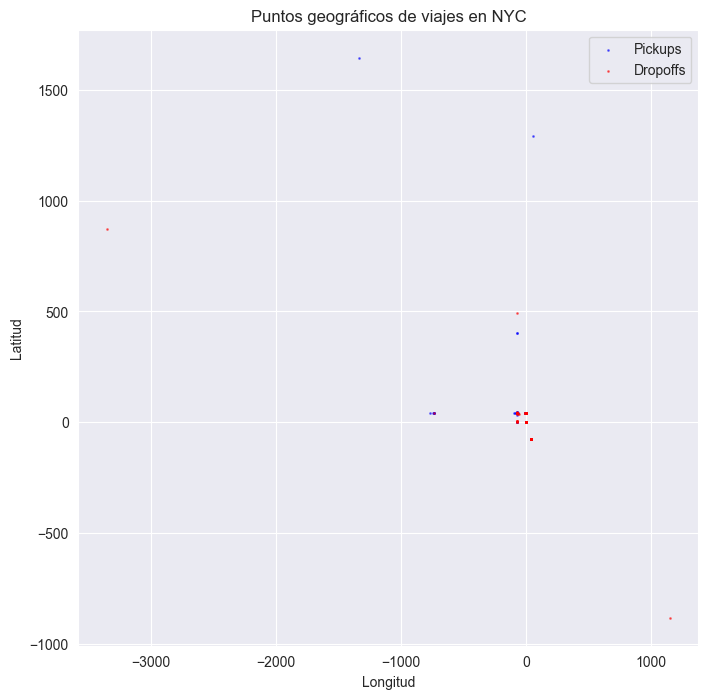

In [12]:
#Ploteamos la latitud y longitud para ver que puntos estan fuera de rango.
plt.figure(figsize=(8,8))
plt.scatter(
    df_uber["pickup_longitude"], df_uber["pickup_latitude"],
    c="blue", s=1, alpha=0.5, label="Pickups"
)
plt.scatter(
    df_uber["dropoff_longitude"], df_uber["dropoff_latitude"],
    c="red", s=1, alpha=0.5, label="Dropoffs"
)

plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend()
plt.title("Puntos geográficos de viajes en NYC")
#Se limitan los ejes para poder ver en escala.
#plt.xlim(-70, -90)
#plt.ylim(40.5, 41.0)
plt.show()


In [13]:
# Utilizamos una funcion auxiliar para validar que la latitud y la longitud sean coordenadas que pertenecientes a la ciudad de new york, si no es así, reemplazamos por nulos para luego rellenarlos con el metodo de knn

def es_coord_ny(lat, lon):
    """
    Valida si una coordenada está dentro de los límites de NYC mas
    un radio de 50 km para viajes por fuera.
    """
    return (40.5 <= lat <= 41.0) and (-74.3 <= lon <= -73.6)


# Aplico es_coord True: Dentro NYC False:Fuera NYC (Valido Lat, Long)
df_uber["pickup_en_ny"] = df_uber.apply(lambda row: es_coord_ny(row["pickup_latitude"], row["pickup_longitude"]), axis=1)
df_uber["dropoff_en_ny"] = df_uber.apply(lambda row: es_coord_ny(row["dropoff_latitude"], row["dropoff_longitude"]), axis=1)

#  Valido punto de partida y llegada dentro de la zona definida.
df_uber["viaje_en_ny"] = df_uber["pickup_en_ny"] & df_uber["dropoff_en_ny"]
df_uber.describe()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,datetime,temperature,humidity,year,diff
count,1.999780e+05,199978,199978.000000,199978,199978.000000,199978.000000,199977.000000,199977.000000,199978.000000,199978,199978.000000,199978.000000,199978.000000,199978
mean,2.771229e+07,2012-03-22 14:08:03.544570368,11.362649,2012-03-22 14:08:03.544569600,-72.527851,39.935999,-72.526243,39.924410,1.684480,2012-03-22 13:38:15.702526976,12.006642,68.128394,2011.742307,0 days 00:00:00.000000308
min,1.000000e+00,2009-01-01 01:15:22.000000600,0.010000,2009-01-01 01:15:22,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000,2009-01-01 01:00:00,-20.200000,17.000000,2009.000000,0 days 00:00:00.000000100
25%,1.382519e+07,2010-08-25 09:17:00,6.000000,2010-08-25 09:17:00,-73.992065,40.734795,-73.991407,40.733825,1.000000,2010-08-25 09:00:00,3.900000,53.000000,2010.000000,0 days 00:00:00.000000136
50%,2.774518e+07,2012-03-21 20:28:03.500000512,8.500000,2012-03-21 20:28:03.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000,2012-03-21 20:00:00,12.500000,69.000000,2012.000000,0 days 00:00:00.000000200
75%,4.155540e+07,2013-10-19 01:02:24.250000384,12.500000,2013-10-19 01:02:24.249999872,-73.967155,40.767158,-73.963659,40.768001,2.000000,2013-10-19 01:00:00,20.500000,84.000000,2013.000000,0 days 00:00:00.000000400
max,5.542357e+07,2015-06-30 23:40:39.000000100,499.000000,2015-06-30 23:40:39,57.418457,1644.421482,1153.572603,872.697628,208.000000,2015-06-30 23:00:00,38.600000,100.000000,2015.000000,0 days 00:00:00.000000990
std,1.601400e+07,NaN,9.897079,NaN,11.437257,7.720443,13.115114,6.793438,1.385974,NaN,10.391706,18.589683,1.856277,0 days 00:00:00.000000222


In [14]:
#Vemos que 4121 coordenadas de pickup estan fuera de los limites de new york
df_uber["pickup_en_ny"].value_counts()


pickup_en_ny
True     195858
False      4120
Name: count, dtype: int64

In [15]:
#Vemos que 4121 coordenadas de dropoff estan fuera de los limites de new york
df_uber["dropoff_en_ny"].value_counts()


dropoff_en_ny
True     195860
False      4118
Name: count, dtype: int64

In [16]:
#Reemplamos las coordenadas fuera de zona por valores NULOS para luego rellenarlos con knn.


df_uber.loc[~df_uber["pickup_en_ny"], ["pickup_latitude", "pickup_longitude"]] = np.nan

df_uber.loc[~df_uber["dropoff_en_ny"], ["dropoff_latitude", "dropoff_longitude"]] = np.nan


In [17]:
#Contamos los nulos nuevamente y verificamos que las coordenadas fuera de zona se encuentran nulas.
nulos_por_columna = df_uber.isnull().sum()

print(nulos_por_columna)

key                     0
date                    0
fare_amount             0
pickup_datetime         0
pickup_longitude     4120
pickup_latitude      4120
dropoff_longitude    4118
dropoff_latitude     4118
passenger_count         0
datetime                0
temperature             0
humidity                0
rain_bool               0
year                    0
diff                    0
pickup_en_ny            0
dropoff_en_ny           0
viaje_en_ny             0
dtype: int64


In [18]:
#Verificamos nuevamente el tamanio
df_uber.shape

(199978, 18)

In [19]:
#Se crea df1 copia del df con las coordenadas validadas.
df1 = df_uber.copy()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199978 entries, 0 to 199999
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   key                199978 non-null  int64          
 1   date               199978 non-null  datetime64[ns] 
 2   fare_amount        199978 non-null  float64        
 3   pickup_datetime    199978 non-null  datetime64[ns] 
 4   pickup_longitude   195858 non-null  float64        
 5   pickup_latitude    195858 non-null  float64        
 6   dropoff_longitude  195860 non-null  float64        
 7   dropoff_latitude   195860 non-null  float64        
 8   passenger_count    199978 non-null  int64          
 9   datetime           199978 non-null  datetime64[ns] 
 10  temperature        199978 non-null  float64        
 11  humidity           199978 non-null  int64          
 12  rain_bool          199978 non-null  bool           
 13  year               199978 non-null

In [20]:
#Contamos los valores de los pasajeros
df1["passenger_count"].value_counts()


passenger_count
1      138414
2       29424
5       14005
3        8878
4        4276
6        4271
0         709
208         1
Name: count, dtype: int64

In [21]:
# UberFlash (para envio de paqueteria) y UberXL para viajes de grupos de hasta 6 personas.
#Por lo que el valor atipico en cantidad de pasajeros seria el de 208, que lo vamos a eliminar ya que solo aparece una vez


df1.loc[(df1['passenger_count'] > 6) , 'passenger_count'] = 6
df1["passenger_count"].value_counts()


passenger_count
1    138414
2     29424
5     14005
3      8878
4      4276
6      4272
0       709
Name: count, dtype: int64

In [22]:
#La variable pasajeros la tomaremos como category debido a que el modelo de negocio de uber se base en 3 categorias que determinan la tarifa: Uber Flash, Uber X y Uber XL.


def categoria_uber(df):
    """
    Recibe un DataFrame con la columna 'passenger_count'
    y agrega una nueva columna 'categoria_uber' según la cantidad de pasajeros.
    """

    def asignar_categoria(pasajeros):
        if pasajeros == 0:
            return "Uber Flash"
        elif 1 <= pasajeros <= 4:
            return "Uber X"
        elif pasajeros > 4:
            return "Uber XL"
        else:
            return "Desconocido"

    df["categoria_uber"] = df["passenger_count"].apply(asignar_categoria)
    return df
df1 = categoria_uber(df1)
print(df1)

             key                          date  fare_amount  \
0       24238194 2015-05-07 19:52:06.000000300          7.5   
1       27835199 2009-07-17 20:04:56.000000200          7.7   
2       44984355 2009-08-24 21:45:00.000000610         12.9   
3       25894730 2009-06-26 08:22:21.000000100          5.3   
4       17610152 2014-08-28 17:47:00.000000188         16.0   
...          ...                           ...          ...   
199995  42598914 2012-10-28 10:49:00.000000530          3.0   
199996  16382965 2014-03-14 01:09:00.000000800          7.5   
199997  27804658 2009-06-29 00:42:00.000000780         30.9   
199998  20259894 2015-05-20 14:56:25.000000400         14.5   
199999  11951496 2010-05-15 04:08:00.000000760         14.1   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0      2015-05-07 19:52:06        -73.999817        40.738354   
1      2009-07-17 20:04:56        -73.994355        40.728225   
2      2009-08-24 21:45:00        -74.005043    

In [23]:
df1["categoria_uber"].value_counts()


categoria_uber
Uber X        180992
Uber XL        18277
Uber Flash       709
Name: count, dtype: int64

In [24]:
#Se agrega una columna para extraer el dia de la semana en el que se hizo el viaje.Lunes= 0 y Domingo = 6
df1['date'] = pd.to_datetime(df1['date'])

df1['dia_de_la_semana'] = df1['date'].dt.weekday
df1['dia_de_la_semana'].value_counts()

dia_de_la_semana
4    30874
5    30250
3    30018
2    29034
1    28121
6    26439
0    25242
Name: count, dtype: int64

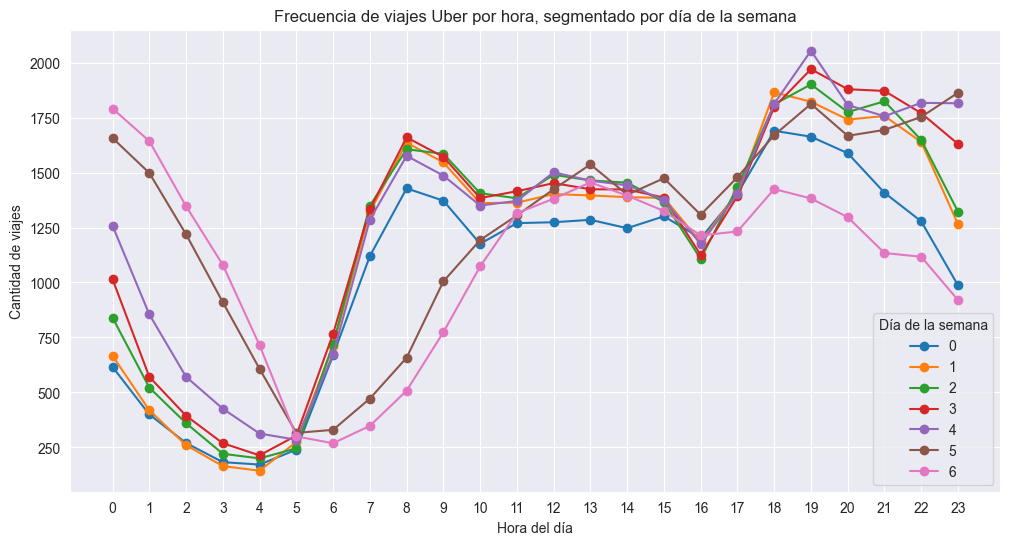

In [25]:
#Graficamos la tabla de frecuencia por hora y dia de la semana para con el objetivo de conocer la distribucion

# Extraer la hora de pickup_datetime
df1["hour"] = pd.to_datetime(df1["pickup_datetime"]).dt.hour

conteo = df1.groupby(["dia_de_la_semana", "hour"]).size().reset_index(name="viajes")


plt.figure(figsize=(12,6))
for dia in conteo["dia_de_la_semana"].unique():
    subset = conteo[conteo["dia_de_la_semana"] == dia]
    plt.plot(subset["hour"], subset["viajes"], marker="o", label=dia)

plt.xlabel("Hora del día")
plt.ylabel("Cantidad de viajes")
plt.title("Frecuencia de viajes Uber por hora, segmentado por día de la semana")
plt.xticks(range(24))
plt.legend(title="Día de la semana")
plt.show()




In [26]:
#Se puede observar como los Lunes, Martes, Miercoles y Jueves presentan casi la misma distribucion y como esto cambia para el viernes, sabado y domingo aunque siembre manteniendo la tendencia.


In [27]:
#Se crea una columna para indicar la franja horaria donde ocurrio el viaje.

df1['pickup_datetime'] = df1['date'].dt.hour
df1
def franja(hora):
  if(0 <= hora <6):
    return 'Madrugada'
  elif(6<= hora <12):
    return 'Mañana'
  elif(12<= hora <18):
    return 'Tarde'
  elif(18<= hora <= 23):
    return 'Noche'

df1['franja_horaria'] = df1['pickup_datetime'].apply(franja)
df1['franja_horaria'].value_counts()

franja_horaria
Noche        68697
Tarde        57380
Mañana       48144
Madrugada    25757
Name: count, dtype: int64

In [28]:
#Se utiliza la libreria Holidays para crear una columna que indique si el dia es feriado.

us_holidays = holidays.US(years=df1["date"].dt.year.unique())

df1["Feriado"] = df1["date"].dt.date.isin(us_holidays)
df1["Feriado"].value_counts()


Feriado
False    195454
True       4524
Name: count, dtype: int64

In [29]:
#Creamos una columna que determina en que semana del mes se produjo ese cambio.
def semana_del_mes(dt):
    dia = dt.day
    if 1 <= dia <= 7:
        return 1
    elif 8 <= dia <= 15:
        return 2
    elif 16 <= dia <= 23:
        return 3
    else:
        return 4

df1["week_of_month"] = df1["date"].apply(semana_del_mes)
df1["week_of_month"] .value_counts()


week_of_month
3    54162
2    53895
4    47156
1    44765
Name: count, dtype: int64

In [30]:
df1['temp_extrema']= ~df1["temperature"].between(0, 40)

In [31]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199978 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   key                199978 non-null  int64          
 1   date               199978 non-null  datetime64[ns] 
 2   fare_amount        199978 non-null  float64        
 3   pickup_datetime    199978 non-null  int32          
 4   pickup_longitude   195858 non-null  float64        
 5   pickup_latitude    195858 non-null  float64        
 6   dropoff_longitude  195860 non-null  float64        
 7   dropoff_latitude   195860 non-null  float64        
 8   passenger_count    199978 non-null  int64          
 9   datetime           199978 non-null  datetime64[ns] 
 10  temperature        199978 non-null  float64        
 11  humidity           199978 non-null  int64          
 12  rain_bool          199978 non-null  bool           
 13  year               199978 non-null

In [32]:

#Borro las columnas que no necesito para entrenar mi modelo

df1 = df1.drop(
    [
        'key', 'date', 'pickup_datetime',
        'passenger_count', 'pickup_en_ny', 'dropoff_en_ny', 'viaje_en_ny','diff','year','humidity','temperature','hour','datetime'
    ],
    axis=1
)

df1.columns


Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'rain_bool', 'categoria_uber',
       'dia_de_la_semana', 'franja_horaria', 'Feriado', 'week_of_month',
       'temp_extrema'],
      dtype='object')

In [33]:
def barrio_nyc(lat, lon):
    # Diccionario con rangos aproximados (lat_min, lat_max, lon_min, lon_max)
    barrios = {
        "Manhattan":   (40.7000, 40.8800, -74.0200, -73.9300),
        "Brooklyn":    (40.5700, 40.7400, -74.0500, -73.8500),
        "Queens":      (40.5400, 40.8000, -73.9600, -73.7000),
        "Bronx":       (40.7900, 40.9200, -73.9300, -73.7600),
        "Staten Island": (40.4800, 40.6500, -74.2500, -74.0500),
    }

    for barrio, (lat_min, lat_max, lon_min, lon_max) in barrios.items():
        if lat_min <= lat <= lat_max and lon_min <= lon <= lon_max:
            return barrio
    return "Fuera de NYC"
df1["barrio"] = df1.apply(
    lambda row: barrio_nyc(row["pickup_latitude"], row["pickup_longitude"]),
    axis=1
)
# Verificar resultado
print(df1[["pickup_latitude", "pickup_longitude", "barrio"]].head(30))
df1['barrio'].value_counts()

    pickup_latitude  pickup_longitude        barrio
0         40.738354        -73.999817     Manhattan
1         40.728225        -73.994355     Manhattan
2         40.740770        -74.005043     Manhattan
3         40.790844        -73.976124     Manhattan
4         40.744085        -73.925023        Queens
5         40.755910        -73.969019     Manhattan
6         40.693965        -73.961447      Brooklyn
7               NaN               NaN  Fuera de NYC
8         40.745767        -73.975187     Manhattan
9         40.741787        -74.001065     Manhattan
10        40.746952        -73.974388     Manhattan
11              NaN               NaN  Fuera de NYC
12        40.804440        -73.966378     Manhattan
13        40.767382        -73.953352     Manhattan
14        40.755193        -73.973370     Manhattan
15        40.751920        -73.990718     Manhattan
16        40.756982        -73.988908     Manhattan
17        40.741138        -74.005665     Manhattan
18        40

barrio
Manhattan        183810
Queens             8743
Fuera de NYC       4315
Brooklyn           2879
Bronx               217
Staten Island        14
Name: count, dtype: int64

In [34]:
#Convertimos las columnas numéricas a categóricas
df1['franja_horaria'] = df1['franja_horaria'].astype('category')
df1['Feriado'] = df1['Feriado'].astype('category')
df1['dia_de_la_semana'] = df1['dia_de_la_semana'].astype('category')
df1['week_of_month'] = df1['week_of_month'].astype('category')
df1['temp_extrema'] = df1['temp_extrema'].astype('category')
df1['barrio'] = df1['barrio'].astype('category')

df1.isna().sum()


fare_amount             0
pickup_longitude     4120
pickup_latitude      4120
dropoff_longitude    4118
dropoff_latitude     4118
rain_bool               0
categoria_uber          0
dia_de_la_semana        0
franja_horaria          0
Feriado                 0
week_of_month           0
temp_extrema            0
barrio                  0
dtype: int64

In [35]:
#One Hot Encoding

categorical_cols = ['franja_horaria', 'Feriado', 'dia_de_la_semana', 'week_of_month','categoria_uber','franja_horaria','temp_extrema','rain_bool','barrio']

encoder = OneHotEncoder(sparse_output=False, drop='first')


encoded_array = encoder.fit_transform(df1[categorical_cols])


encoded_df = pd.DataFrame(
    encoded_array,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=df1.index
)
df_encoded = pd.concat([df1.drop(columns=categorical_cols), encoded_df], axis=1)
df_encoded = df_encoded.drop(columns=['distance_km'], errors='ignore')


In [36]:
df_encoded.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,franja_horaria_Mañana,franja_horaria_Noche,franja_horaria_Tarde,Feriado_1.0,dia_de_la_semana_1,...,franja_horaria_Mañana,franja_horaria_Noche,franja_horaria_Tarde,temp_extrema_1.0,rain_bool_True,barrio_Brooklyn,barrio_Fuera de NYC,barrio_Manhattan,barrio_Queens,barrio_Staten Island
0,7.5,-73.999817,40.738354,-73.999512,40.723217,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,7.7,-73.994355,40.728225,-73.994710,40.750325,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,12.9,-74.005043,40.740770,-73.962565,40.772647,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,16.0,-73.925023,40.744085,-73.973082,40.761247,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [37]:
x_train, x_test, y_train, y_test = train_test_split(
    df_encoded.drop(columns='fare_amount'), df_encoded['fare_amount'], test_size=0.2, random_state=42)
x_train.isna().sum()

pickup_longitude          3311
pickup_latitude           3311
dropoff_longitude         3308
dropoff_latitude          3308
franja_horaria_Mañana        0
franja_horaria_Noche         0
franja_horaria_Tarde         0
Feriado_1.0                  0
dia_de_la_semana_1           0
dia_de_la_semana_2           0
dia_de_la_semana_3           0
dia_de_la_semana_4           0
dia_de_la_semana_5           0
dia_de_la_semana_6           0
week_of_month_2              0
week_of_month_3              0
week_of_month_4              0
categoria_uber_Uber X        0
categoria_uber_Uber XL       0
franja_horaria_Mañana        0
franja_horaria_Noche         0
franja_horaria_Tarde         0
temp_extrema_1.0             0
rain_bool_True               0
barrio_Brooklyn              0
barrio_Fuera de NYC          0
barrio_Manhattan             0
barrio_Queens                0
barrio_Staten Island         0
dtype: int64

In [38]:
cols_knn = [
    'pickup_longitude','pickup_latitude',
    'dropoff_longitude','dropoff_latitude'
]
cols_knn = [c for c in cols_knn if c in x_train.columns]

imputer = KNNImputer(n_neighbors=5, weights='distance')
x_train.loc[:, cols_knn] = imputer.fit_transform(x_train[cols_knn])
x_test.loc[:,  cols_knn] = imputer.transform(x_test[cols_knn])

In [39]:
x_train1 = x_train.copy(deep=True)
x_test1  = x_test.copy(deep=True)


In [40]:
#Ahora calculamos la distancia utilizando GEOPY

def calculate_distance(row):
    start = (row['pickup_latitude'], row['pickup_longitude'])
    end = (row['dropoff_latitude'], row['dropoff_longitude'])
    return geodesic(start, end).kilometers

# Aplica la función
x_train1['distance_km'] = x_train1.apply(calculate_distance, axis=1)
x_test1['distance_km'] = x_test1.apply(calculate_distance, axis=1)


In [41]:
x_train1['distance_km'].head(-1)

183960    4.398992
15044     5.758228
11425     3.792179
138866    1.425716
74154     0.664306
            ...   
110278    1.525132
119890    0.232549
103703    1.923067
131943    0.672561
146879    1.434613
Name: distance_km, Length: 159981, dtype: float64

In [42]:
#Los valores con distancias menores a 100 metros los reemplazaremos por la mediana debido al supuesto de que son viajes que empiezan y terminan en la misma coordenada.


mediana_distancia_train = x_train1.loc[x_train1['distance_km'] >= 0.1, 'distance_km'].median()

x_train1.loc[x_train1['distance_km'] < 0.1, 'distance_km'] = mediana_distancia_train

# Reemplazar distancias == 0 en X_test usando la misma mediana
x_test1.loc[x_test1['distance_km'] < 0.1, 'distance_km'] = mediana_distancia_train
#x_train1.describe()
x_train1[x_train1['distance_km'] < 0.1].count()


pickup_longitude          0
pickup_latitude           0
dropoff_longitude         0
dropoff_latitude          0
franja_horaria_Mañana     0
franja_horaria_Noche      0
franja_horaria_Tarde      0
Feriado_1.0               0
dia_de_la_semana_1        0
dia_de_la_semana_2        0
dia_de_la_semana_3        0
dia_de_la_semana_4        0
dia_de_la_semana_5        0
dia_de_la_semana_6        0
week_of_month_2           0
week_of_month_3           0
week_of_month_4           0
categoria_uber_Uber X     0
categoria_uber_Uber XL    0
franja_horaria_Mañana     0
franja_horaria_Noche      0
franja_horaria_Tarde      0
temp_extrema_1.0          0
rain_bool_True            0
barrio_Brooklyn           0
barrio_Fuera de NYC       0
barrio_Manhattan          0
barrio_Queens             0
barrio_Staten Island      0
distance_km               0
dtype: int64

In [43]:
#Elimino coordenadas
cols_drop = ['pickup_longitude','pickup_latitude',
             'dropoff_longitude','dropoff_latitude']

for X in (x_train1, x_test1):
    X.drop(columns=[c for c in cols_drop if c in X.columns], inplace=True)
#x_train.isna().sum()
x_test.isna().sum()

pickup_longitude          0
pickup_latitude           0
dropoff_longitude         0
dropoff_latitude          0
franja_horaria_Mañana     0
franja_horaria_Noche      0
franja_horaria_Tarde      0
Feriado_1.0               0
dia_de_la_semana_1        0
dia_de_la_semana_2        0
dia_de_la_semana_3        0
dia_de_la_semana_4        0
dia_de_la_semana_5        0
dia_de_la_semana_6        0
week_of_month_2           0
week_of_month_3           0
week_of_month_4           0
categoria_uber_Uber X     0
categoria_uber_Uber XL    0
franja_horaria_Mañana     0
franja_horaria_Noche      0
franja_horaria_Tarde      0
temp_extrema_1.0          0
rain_bool_True            0
barrio_Brooklyn           0
barrio_Fuera de NYC       0
barrio_Manhattan          0
barrio_Queens             0
barrio_Staten Island      0
dtype: int64

In [44]:
#Escalo la distancia
scaler_dist = StandardScaler()
x_train1['distance_km'] = scaler_dist.fit_transform(x_train1[['distance_km']])
x_test1['distance_km'] = scaler_dist.transform(x_test1[['distance_km']])

x_test1.isna().sum()


franja_horaria_Mañana     0
franja_horaria_Noche      0
franja_horaria_Tarde      0
Feriado_1.0               0
dia_de_la_semana_1        0
dia_de_la_semana_2        0
dia_de_la_semana_3        0
dia_de_la_semana_4        0
dia_de_la_semana_5        0
dia_de_la_semana_6        0
week_of_month_2           0
week_of_month_3           0
week_of_month_4           0
categoria_uber_Uber X     0
categoria_uber_Uber XL    0
franja_horaria_Mañana     0
franja_horaria_Noche      0
franja_horaria_Tarde      0
temp_extrema_1.0          0
rain_bool_True            0
barrio_Brooklyn           0
barrio_Fuera de NYC       0
barrio_Manhattan          0
barrio_Queens             0
barrio_Staten Island      0
distance_km               0
dtype: int64

In [45]:
lr = LinearRegression()
lr.fit(x_train1, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [46]:
y_pred = lr.predict(x_test1)

In [47]:
lr.coef_, lr.intercept_

(array([ 3.91927169e-01,  1.61317376e-01,  6.04379642e-01, -4.97429162e-01,
         1.58422057e-01,  3.56601252e-01,  4.65956351e-01,  4.76260706e-01,
         2.00331873e-02, -1.85037412e-02, -1.26287400e-02,  9.82740807e-03,
        -3.22476040e-02,  1.03560570e+00,  1.08253942e+00,  3.91927169e-01,
         1.61317376e-01,  6.04379642e-01,  1.02319655e-01,  1.47194264e-01,
        -1.37228683e+00,  2.54890398e+00, -1.92864445e+00,  1.42930015e+00,
         1.08488812e+01,  7.98465474e+00]),
 np.float64(11.110844535091063))

In [48]:
lr.score(x_train1,y_train), lr.score(x_test1,y_test)

(0.7025010133633156, 0.7215301728275014)

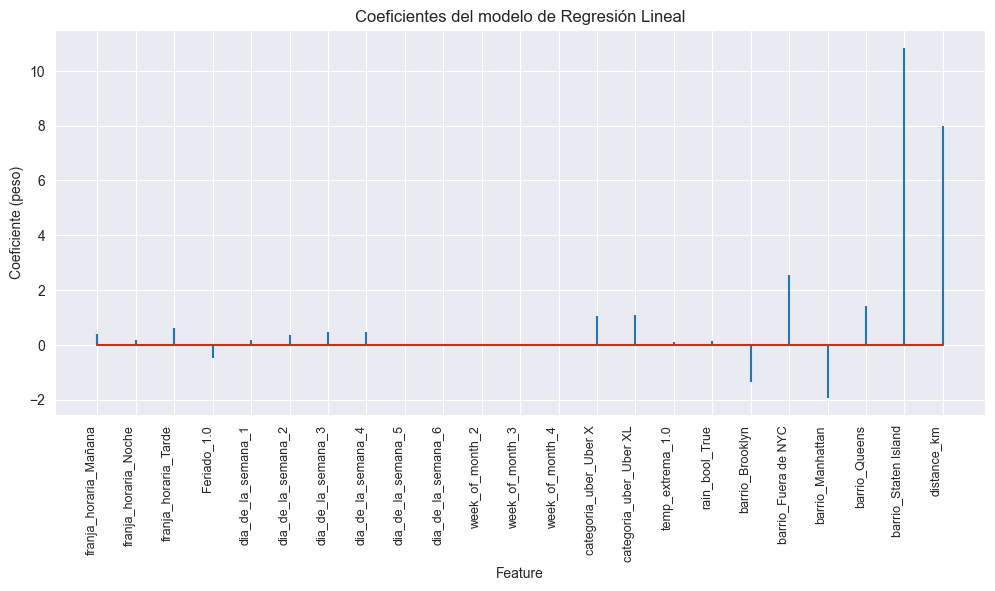

In [49]:
# DataFrame con coeficientes y nombres de columnas
df_coeficientes = pd.DataFrame({
    'predictor': x_train1.columns,
    'coef': lr.coef_.flatten()
})

# Gráfico
fig, ax = plt.subplots(figsize=(12, 5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=9)
ax.set_xlabel('Feature')
ax.set_ylabel('Coeficiente (peso)')
ax.set_title('Coeficientes del modelo de Regresión Lineal')
plt.show()



df_coeficientes

In [50]:
df_coeficientes

,predictor,coef
0,franja_horaria_Mañana,0.391927
1,franja_horaria_Noche,0.161317
2,franja_horaria_Tarde,0.604380
3,Feriado_1.0,-0.497429
4,dia_de_la_semana_1,0.158422
5,dia_de_la_semana_2,0.356601
6,dia_de_la_semana_3,0.465956
7,dia_de_la_semana_4,0.476261
8,dia_de_la_semana_5,0.020033
9,dia_de_la_semana_6,-0.018504


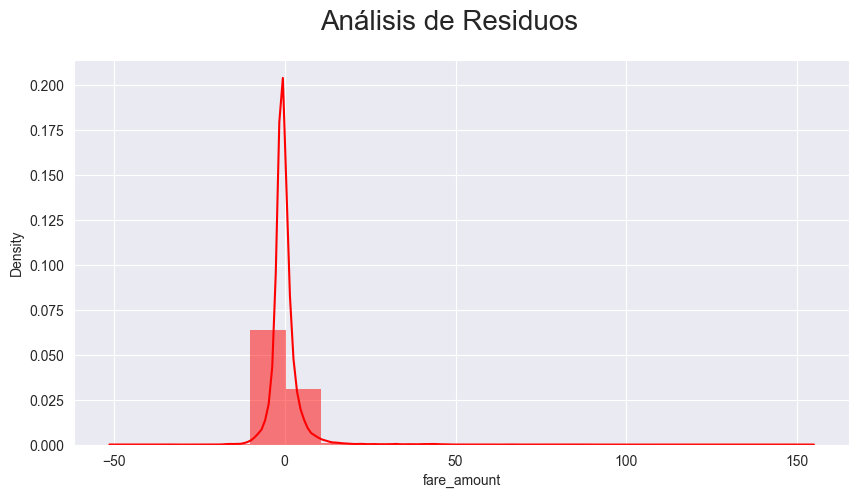

In [51]:



fig = plt.figure(figsize=(10,5))

sns.histplot((y_test - y_pred), color="red", kde=True, stat="density", linewidth=0,bins=20)
fig.suptitle('Análisis de Residuos', fontsize = 20)
plt.show()


GRADIENTE DESCENDIENTE


In [52]:
# definición de funciones de pérdida distintas y sus derivadas.
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_gradient(X, y_true, y_pred):
    n = X.shape[0]
    return -(2/n) * (X.T @ (y_true - y_pred))

def mae_loss(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mae_gradient(X, y_true, y_pred):
    n = X.shape[0]
    return -(1/n) * (X.T @ np.sign(y_true - y_pred))

In [53]:
def plot_loss(train_errors, val_errors):
    # gráfico de errores.
    plt.figure(figsize=(12, 4))
    plt.plot(train_errors, label='train_loss')
    plt.plot(val_errors, label='val_loss')
    plt.xlabel('Iteración')
    plt.ylabel('Loss')
    plt.title('Evolución de función de pérdida vs iteraciones')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_parameters(coef_history):
    # gráfico de coeficientes.
    coef_history = np.array(coef_history)
    plt.figure(figsize=(12, 4))
    for j in range(coef_history.shape[1]):
        plt.plot(coef_history[:, j], label=f'beta_{j}')
    plt.xlabel('Iteración')
    plt.ylabel('Valor del coeficiente')
    plt.title('Evolución de los coeficientes')
    plt.legend()
    plt.grid(True)
    plt.show()

In [54]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100, grad_fn=mse_gradient):
    """
    """

    y_train = y_train.values.reshape(-1, 1)
    y_val = y_val.values.reshape(-1, 1)

    # se guardan dimensiones
    n, m = X_train.shape
    o = X_val.shape[0]

    # se agrega columna de unos a las matrices X para considerar los términos independientes (no hacerlo implica forzar término independiente a nulo)
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    # se inicializan pesos aleatorios (m+1)x1
    W = np.random.randn(m+1, 1)

    # listas para guardar evolución de errores y coeficientes a lo largo de las iteraciones
    # los coeficientes ya tienen un valor inicial (W).
    train_errors, val_errors, coef_history = [], [], [W.flatten()]

    for _ in range(epochs):
        # como ya hay una inicialización de los coeficientes, se calcula con ellos el ajuste al conjunto de entrenamiento y validación.
        y_pred_train = X_train @ W
        y_pred_val = X_val @ W

        error_train = y_train - y_pred_train
        error_val = y_val - y_pred_val

        train_mse = np.mean(error_train ** 2)
        val_mse = np.mean(error_val ** 2)

        train_errors.append(train_mse)
        val_errors.append(val_mse)

        # calculo gradiente , uso la función que se pasa como parámetro.
        gradient = grad_fn(X_train, y_train, y_pred_train)
        W -= lr * gradient

        # se guarda coeficientes para plot.
        coef_history.append(W.flatten())

    plot_loss(train_errors, val_errors)
    plot_parameters(coef_history)

    return W

El error baja muy rápido en las primeras 20 iteraciones
No hay overfitting porque las curvas de entrenamiento y validación son casi idénticas.



Con respecto a los coeficientes en las 50 iteraciones se estabilizan la mayoria.
Los que estan cerca del 0 tienen poca relevancia.
Hay algunos negativos que indican una relacion inversa.

len X_train: 139984, len y_train2: 139984
len X_val: 19998, len y_val: 19998
(139984, 26)
(19998, 26)


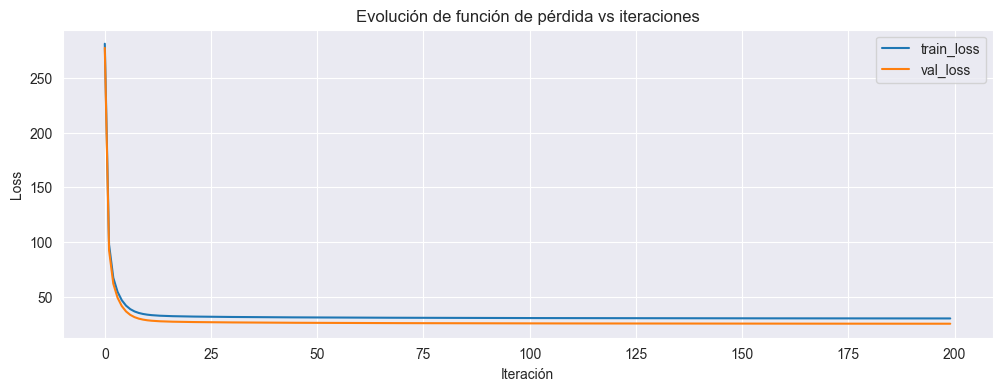

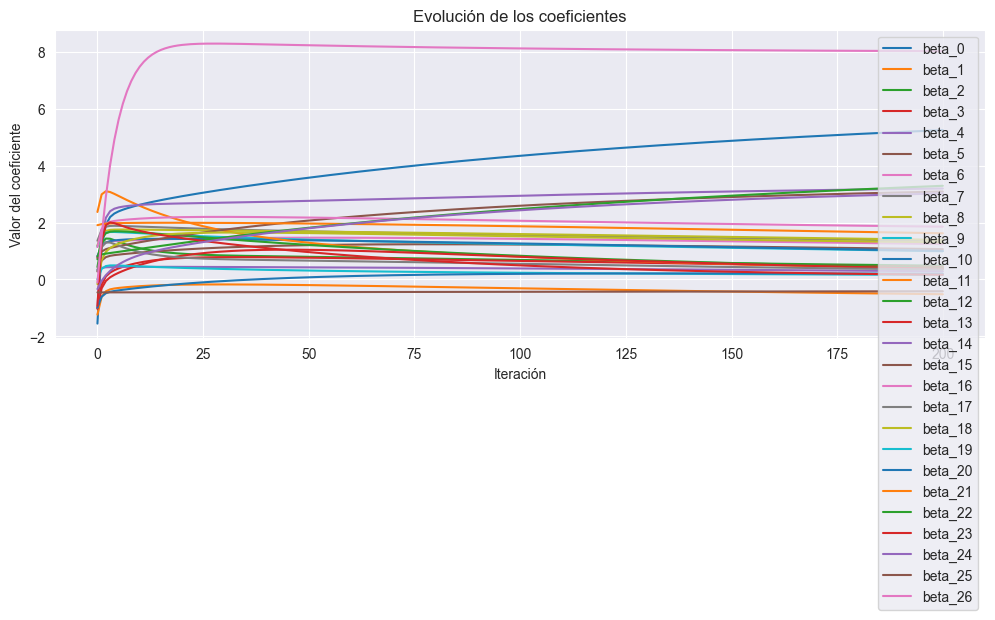

In [55]:
X_train, X_val, y_train2, y_val = train_test_split(x_train1, y_train, test_size=0.125, random_state=42)
print(f"len X_train: {len(X_train)}, len y_train2: {len(y_train2)}")
print(f"len X_val: {len(X_val)}, len y_val: {len(y_val)}")
print(X_train.shape)
print(X_val.shape)
W = gradient_descent(X_train, y_train2, X_val, y_val, lr=0.1, epochs=200)


In [56]:

X_train_ = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
#X_val= X_val.values.reshape(-1, 1)

X_val_ = np.hstack((np.ones((x_test1.shape[0], 1)), x_test1))

print(X_train_.shape)
print(X_val_.shape)
y_pred_train = X_train_ @ W
y_pred_val = X_val_ @ W

print("R2 train:", r2_score(y_train2, y_pred_train))
print("R2 val:", r2_score(y_test, y_pred_val))


(139984, 27)
(39996, 27)
R2 train: 0.6958631389397001
R2 val: 0.7182283772762055


In [57]:
print(lr.score(X_train,y_train2), lr.score(x_test1,y_test))
len(x_train1)

0.6983436640235375 0.7215301728275014


159982

Vemos resultados similares es Regresion lineal y en el Gradiente Descendiente aunque este ultimo presenta un mejor R2 en en conjunto de pruebas


In [58]:
def stochastic_gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100, grad_fn=mse_gradient, batch_size=1):
    """
    """

    y_train = y_train.values.reshape(-1, 1)
    y_val = y_val.values.reshape(-1, 1)

    n, m = X_train.shape
    o = X_val.shape[0]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    W = np.random.randn(m+1, 1)

    train_errors, val_errors, coef_history = [], [], [W.flatten()]

    for _ in range(epochs):
        # se mezclan índices para que cada época tenga distinto orden de muestras
        indices = np.random.permutation(n)

        for i in range(0, n, batch_size):
            batch_idx = indices[i:i+batch_size]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]

            y_pred_batch = X_batch @ W
            gradient = grad_fn(X_batch, y_batch, y_pred_batch)
            W -= lr * gradient

        # errores globales después de cada época
        y_pred_train = X_train @ W
        y_pred_val = X_val @ W
        train_errors.append(np.mean((y_train - y_pred_train) ** 2))
        val_errors.append(np.mean((y_val - y_pred_val) ** 2))

        coef_history.append(W.flatten())

    plot_loss(train_errors, val_errors)
    plot_parameters(coef_history)

    return W

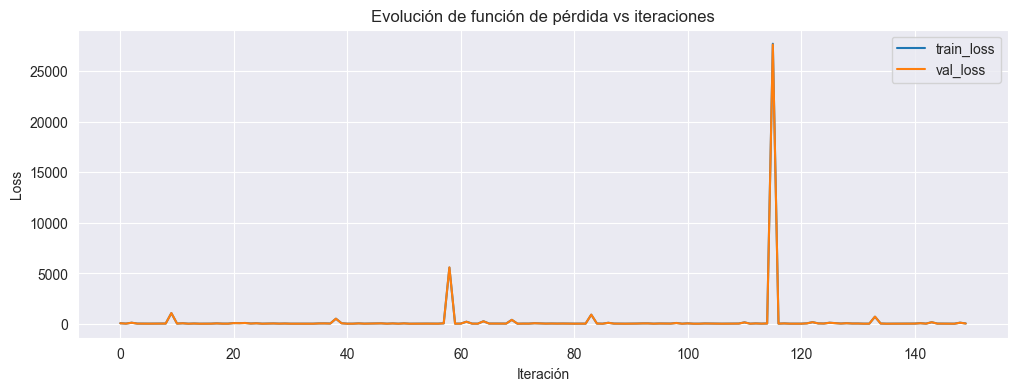

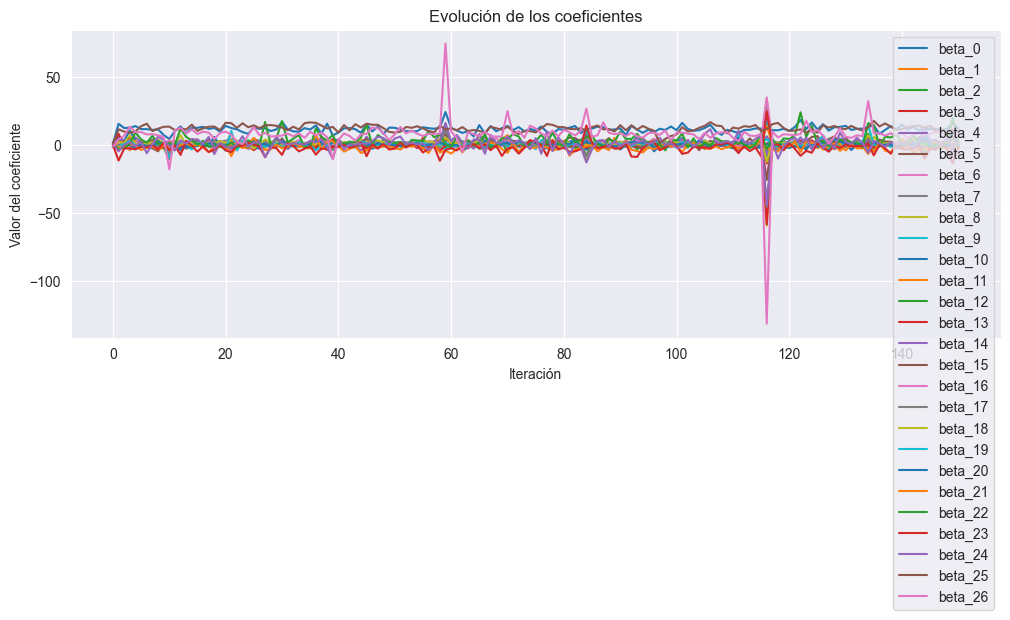

array([[12.04140954],
       [-3.07766822],
       [-1.74248693],
       [-1.72213911],
       [-0.30856466],
       [ 1.67913049],
       [ 3.77220272],
       [ 2.28483239],
       [-0.25583884],
       [-2.30753924],
       [-1.9083663 ],
       [-0.92032034],
       [ 1.6189765 ],
       [ 0.30615919],
       [-0.36776144],
       [ 6.49064579],
       [-1.88794098],
       [-2.16275628],
       [-0.51328351],
       [ 0.02726575],
       [-0.4833745 ],
       [-1.92323351],
       [ 2.07097766],
       [-2.23686463],
       [12.13629844],
       [ 8.61919253],
       [ 6.48434319]])

In [59]:
stochastic_gradient_descent(X_train, y_train2, X_val, y_val, lr=0.05, epochs=150)


In [60]:
def mini_batch_gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100, batch_size=32, grad_fn=mse_gradient):
    """

    """

    y_train = y_train.values.reshape(-1, 1)
    y_val = y_val.values.reshape(-1, 1)

    n, m = X_train.shape
    o = X_val.shape[0]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    W = np.random.randn(m+1, 1)

    train_errors, val_errors, coef_history = [], [], [W.flatten()]

    for _ in range(epochs):
        indices = np.random.permutation(n)

        # usamos batches para el cálculo.
        for i in range(0, n, batch_size):
            batch_idx = indices[i:i+batch_size]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]

            y_pred_batch = X_batch @ W
            gradient = grad_fn(X_batch, y_batch, y_pred_batch)
            W -= lr * gradient

        y_pred_train = X_train @ W
        y_pred_val = X_val @ W
        train_errors.append(np.mean((y_train - y_pred_train) ** 2))
        val_errors.append(np.mean((y_val - y_pred_val) ** 2))

        coef_history.append(W.flatten())

    plot_loss(train_errors, val_errors)
    plot_parameters(coef_history)

    return W

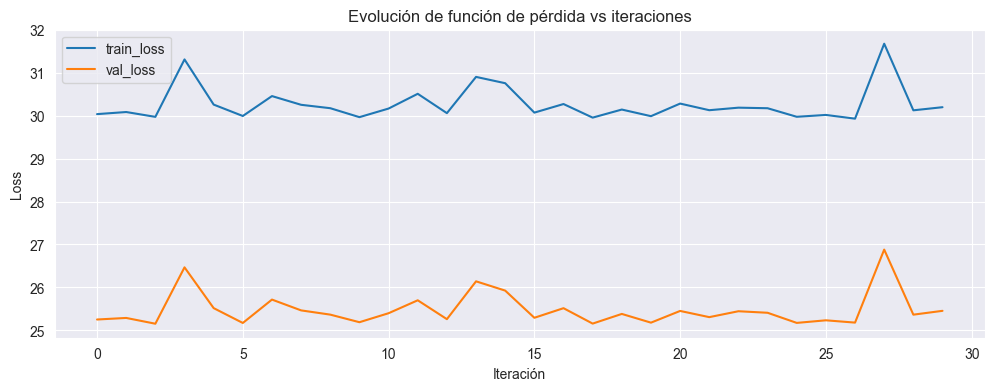

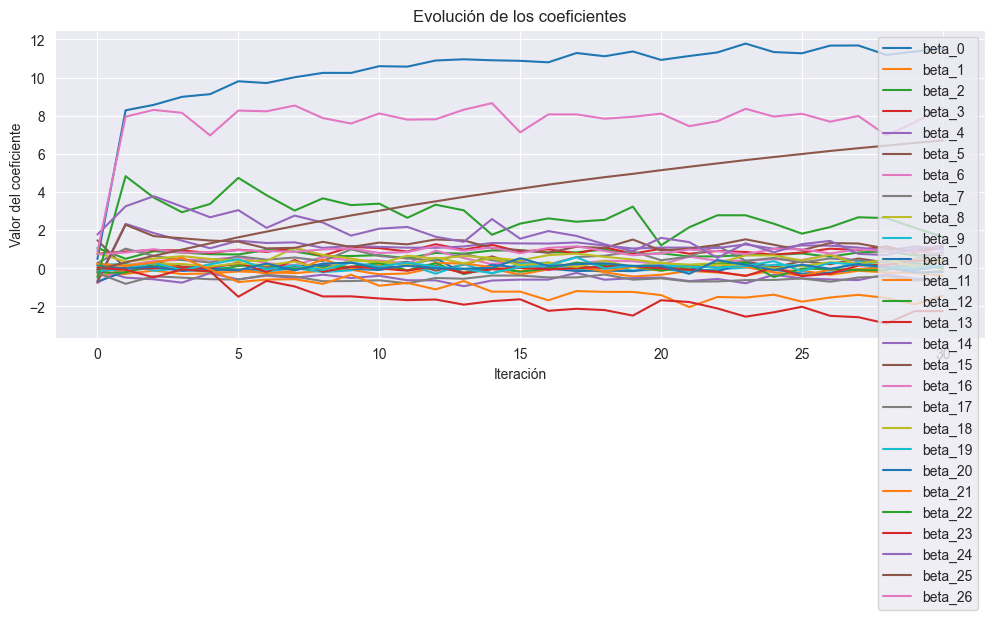

array([[11.52774758],
       [-0.38883893],
       [ 0.70469387],
       [ 1.08908599],
       [-0.6164154 ],
       [ 0.16270253],
       [ 0.31409054],
       [ 0.8449608 ],
       [ 0.48138207],
       [ 0.04489204],
       [ 0.11735073],
       [-0.13350528],
       [-0.02722479],
       [ 0.35610928],
       [ 0.98839306],
       [ 1.19773631],
       [ 0.72920859],
       [-0.60861092],
       [ 0.37935371],
       [ 0.15756132],
       [-0.19492783],
       [-1.43698386],
       [ 1.64208039],
       [-2.24301583],
       [ 1.15596546],
       [ 6.70230979],
       [ 8.42382655]])

In [61]:
mini_batch_gradient_descent(X_train, y_train2, X_val, y_val, lr=0.01, epochs=30, batch_size=7)

REGULARIZACION

Ridge

In [62]:
# Creación y entrenamiento del modelo. Scikit-Learn usa Cross Validation para encontrar el valor óptimo de alpha
# (lambda en los desarrollos de teoría). Puede ser problemático con series de tiempo.

model_ridge = make_pipeline(RidgeCV(
                           alphas          = np.logspace(-3, 6, 200),
                           fit_intercept   = True,

                        )
         )

_ = model_ridge.fit(x_train1, y_train)

NameError: name 'make_pipeline' is not defined

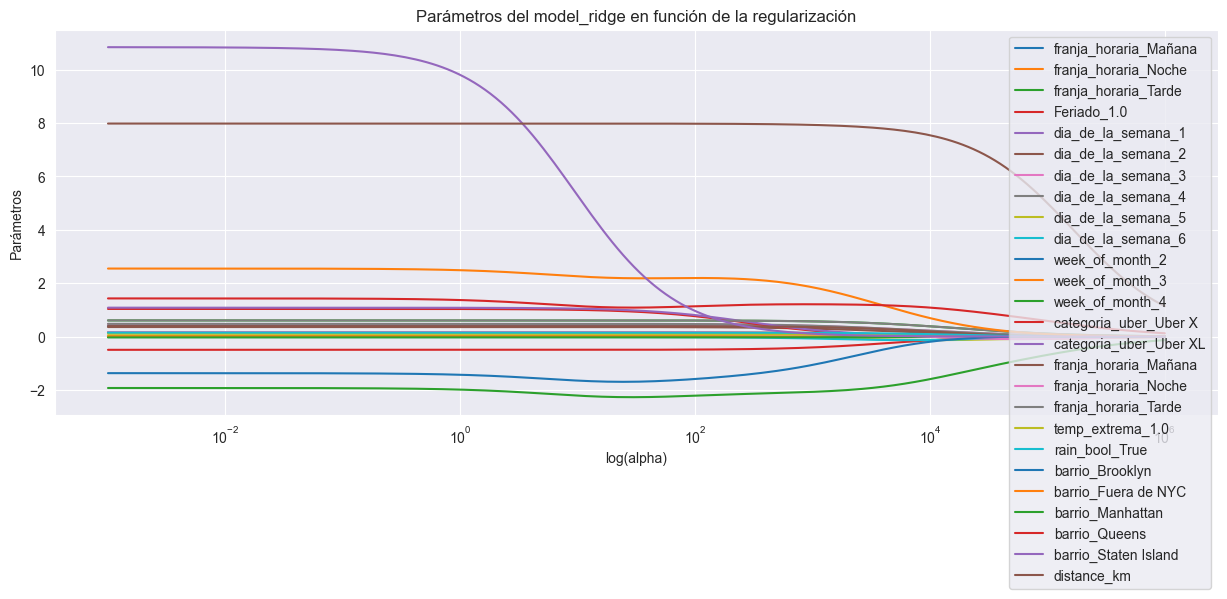

In [190]:
alphas = model_ridge.named_steps["ridgecv"].alphas
coefs = []

for alpha in alphas:
    model_ridge_aux = make_pipeline(Ridge(alpha=alpha))
    model_ridge_aux.fit(x_train1, y_train)
    coefs.append(model_ridge_aux.steps[0][1].coef_.flatten())

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, coefs, label=x_train1.columns)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del model_ridge en función de la regularización')
plt.axis('tight')
plt.legend()
plt.show()

los coeficientes de las variables se reducen progresivamente cuando aumenta alpha.

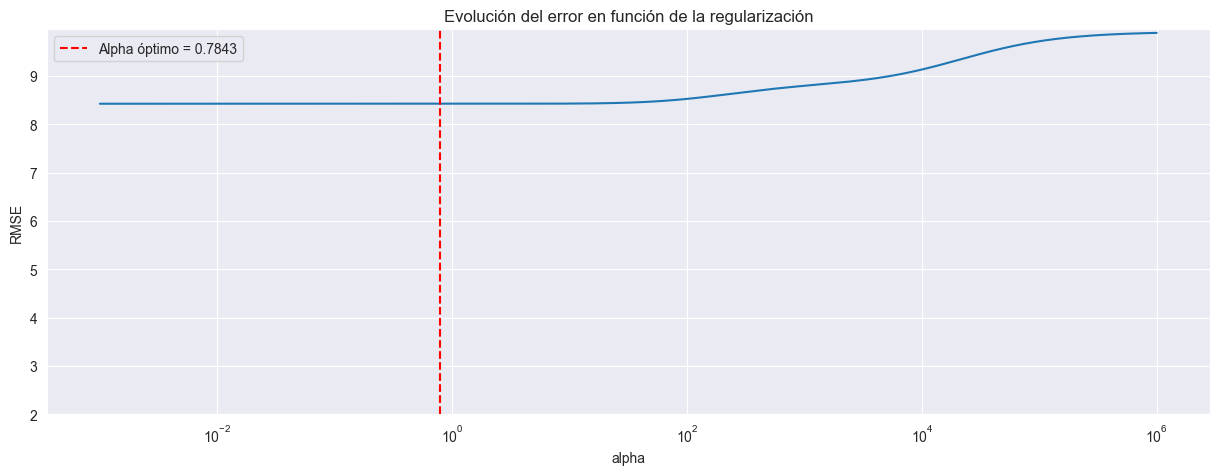

In [191]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

param_grid = {"alpha": np.logspace(-3, 6, 200)}
ridge = Ridge(fit_intercept=True)

grid = GridSearchCV(ridge, param_grid, cv=5, scoring="neg_mean_squared_error")
grid.fit(x_train, y_train)


mse_cv = -grid.cv_results_["mean_test_score"]
rmse_cv = np.sqrt(mse_cv)
alphas = grid.param_grid["alpha"]

optimo = grid.best_params_["alpha"]
min_rmse = np.min(rmse_cv)


fig, ax = plt.subplots(figsize=(15,5))
ax.plot(alphas, rmse_cv)
ax.set_xscale("log")
ax.set_ylim([2,None])
ax.set_title("Evolución del error en función de la regularización")
ax.set_xlabel("alpha")
ax.set_ylabel("RMSE")
plt.axvline(optimo, color="red", linestyle="--", label=f"Alpha óptimo = {optimo:.4f}")
ax.legend()
plt.show()


El error mínimo (RMSE) se obtiene con un alpha cercano a 0.78, y a valores más altos empeoran el ajuste.

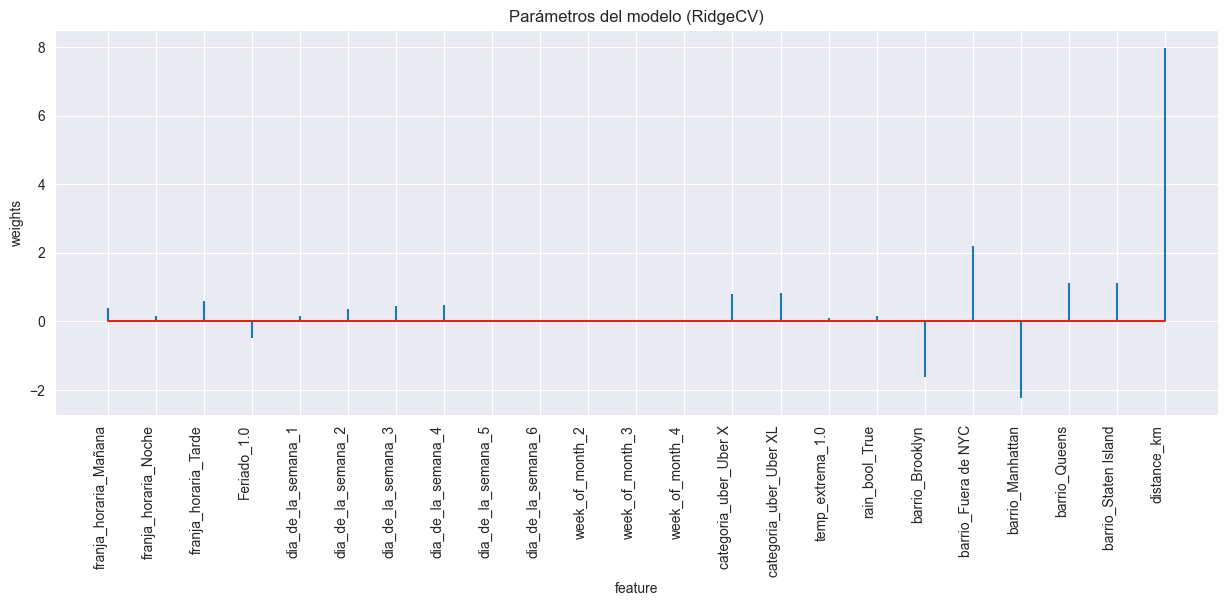

In [193]:

coefs = model_ridge.named_steps["ridgecv"].coef_

# Armar el DataFrame
df_coeficientes = pd.DataFrame({
    'predictor': x_train1.columns,
    'coef': coefs.flatten()
})


fig, ax = plt.subplots(figsize=(15,5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo (RidgeCV)')
plt.show()


variables como distance_km, categoria de Uber y algunos barrios tienen mayor peso

In [195]:
y_pred = model_ridge.predict(x_test1)


In [3]:
# Error de test del modelo
from sklearn.metrics import mean_squared_error

rmse_ridge = mean_squared_error(y_test,
                y_pred,
                squared = False
             )

print(f"El error (rmse) de test es: {rmse_ridge}")

NameError: name 'y_test' is not defined